In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Brain = torch.load( "./actormodel.pth" )

weight_names = []
bias_names = []
weights = []
biases = []

In [2]:
for layer in Brain:
  if 'weight' in layer:
    weights.append(Brain[layer])
    weight_names.append(layer)
  elif 'bias' in layer:
    biases.append(Brain[layer])
    bias_names.append(layer)

weights_shape = [layer.shape for layer in weights]
bias_shape = [layer.shape for layer in biases]

In [3]:
first_layer_weight = weights[0]

def tensor_to_numpy( torch_tensor ):
  # TODO : HOW TO CONVERT GPU TO NUMPY DIRECTLY
  return torch_tensor.cpu().numpy()

np_arr = tensor_to_numpy(first_layer_weight)
np_arr = np_arr.transpose()
print(np_arr.shape)

(29, 300)


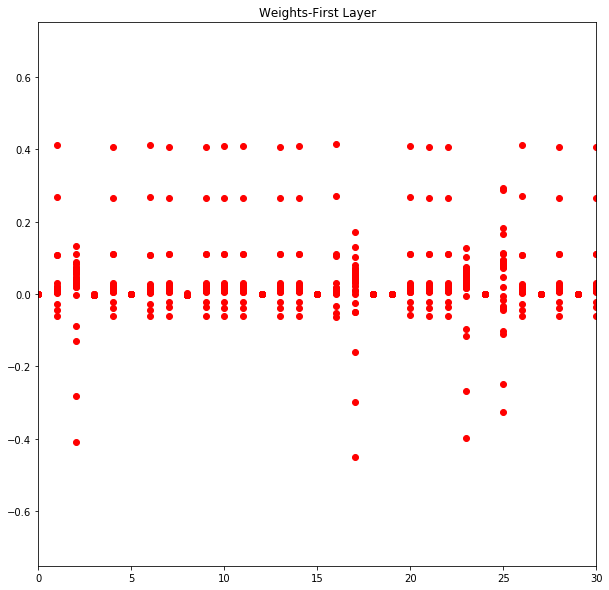

In [30]:
fig   = plt.figure(figsize=(10,10))

ax_fig_1_1 = fig.add_subplot(111)

ax_fig_1_1.clear()

ax_fig_1_1.axis([0, 30, -0.75, 0.75])
ax_fig_1_1.plot(np_arr.transpose(),'ro')
ax_fig_1_1.title.set_text('Weights-First Layer')
# ax_fig_1_1.invert_yaxis()

# from mpl_toolkits.mplot3d import Axes3D
# fig1 = plt.figure()
# ax = fig1.add_subplot(111, projection='3d')
# ax.scatter3D( np.array(29,1),np.array(300,1), 1, cmap='hsv');

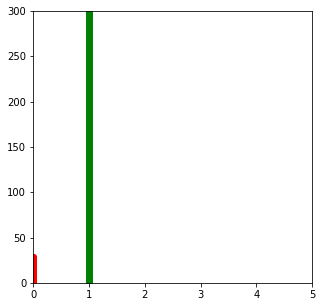

In [24]:
# x = range(1, 300, math.ceil(300/29.7) )
   
fig2   = plt.figure(figsize=(5,5))
ax_fig = fig2.add_subplot(111)
ax_fig.clear()

# Length of X : Number of hidden layers
# Length of Y : Layer size of biggest number of neurons
ax_fig.axis([0, 5, 0, 300])

def create_layer( neuron_numbers, layer_number , offset = 0 ):
    neuron_list_x = []
    neuron_list_y = []
    for x in range(neuron_numbers):
        neuron_list_y.append(x+1)
        neuron_list_x.append(layer_number)

    neuron_list = [ neuron_list_x,neuron_list_y ]

    neuron_list = np.asarray(neuron_list)
    
    return neuron_list

first_layer = create_layer(29,0)
second_layer = create_layer(300,1)


ax_fig.plot(first_layer[0],first_layer[1],'ro')
ax_fig.plot(second_layer[0],second_layer[1],'go')

# ax_fig.title.set_text('Weights-First Layer')

# ax_fig_1_1.invert_yaxis()

plt.show()

In [ ]:
# TODO : 
# 1 : Auto size layer coordinates 
#     map 29 to somewhere near 300 (NORMALIZATION)
# 2: Plot weights with 'alpha' coefficient